# Create BGC open boundary condition for regional MITgcm based on GLODAPv2 and Huang et al (2022) Fe
    - For DIC, Alk, O2, NO3, PO4, we will use GLODAPv2 https://glodap.info/
    - For Fe, we use the gridded data of Huang et al., (2022) https://zenodo.org/record/6994318
    - This will be annual mean field

In [1]:
import numpy as np
import xarray as xr
import xmitgcm as xm
import os
from scipy.interpolate import RectBivariateSpline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
print('===== develop init cond ')
vars0 = ['tco2', 'talk', 'oxygen', 'phosphate', 'nitrate', 'dFe_RF']
vars1 = ['dic', 'alk', 'o2', 'po4', 'no3', 'fe']
srcdir = './GLODAPv2_Mapped_Climatologies'
caseroot = './'
ffe='Monthly_dFe_V2.nc'

===== develop init cond 


In [3]:
# define new grid
runcase = 'NorthPacific.lonlat2x2.42lev'
rname = 'NorthPacific'
xrange = [131, 249]  # zonal extent
yrange = [5, 62]  # meridional extent
n = [60, 40]   # number of grid points

In [4]:
#define a new grid coordinates
xn = np.linspace(xrange[0], xrange[1], n[0])
yn = np.linspace(yrange[0], yrange[1], n[1])
zn=np.array([-5.0000e+00, -1.5500e+01, -2.7000e+01, -3.9500e+01, -5.3000e+01,
       -6.8000e+01, -8.5000e+01, -1.0400e+02, -1.2550e+02, -1.5000e+02,
       -1.7750e+02, -2.0850e+02, -2.4350e+02, -2.8300e+02, -3.2800e+02,
       -3.7950e+02, -4.3850e+02, -5.0600e+02, -5.8300e+02, -6.7100e+02,
       -7.7200e+02, -8.8800e+02, -1.0210e+03, -1.1735e+03, -1.3485e+03,
       -1.5495e+03, -1.7805e+03, -2.0460e+03, -2.3190e+03, -2.5750e+03,
       -2.8250e+03, -3.0750e+03, -3.3250e+03, -3.5750e+03, -3.8250e+03,
       -4.0750e+03, -4.3250e+03, -4.5750e+03, -4.8250e+03, -5.0750e+03,
       -5.3250e+03, -5.5750e+03], dtype=float) * -1
#
# print the values of x0 and y0
x0 = xn[0]-(xn[1]-xn[0])/2.
y0 = yn[0]-(yn[1]-yn[0])/2.
print('x0='+str(x0))
print('y0='+str(y0))
#
# print the number of grid points in x, y and z
print('Nx='+str(xn.size))
print('Ny='+str(yn.size))
print('Nz='+str(zn.size))

x0=130.0
y0=4.269230769230769
Nx=60
Ny=40
Nz=42


In [5]:
vref = [2000, 2300, 170, 2, 30, 1e-3]
dx = np.diff(xn)
dy = np.diff(yn)
Nt = 1
# initialize array
N=n
Nt=12
tmpE1 = np.zeros((6, Nt, 42, N[1]))
tmpW1 = np.zeros((6, Nt, 42, N[1]))
tmpN1 = np.zeros((6, Nt, 42, N[0]))
tmpS1 = np.zeros((6, Nt, 42, N[0]))

Working on dic


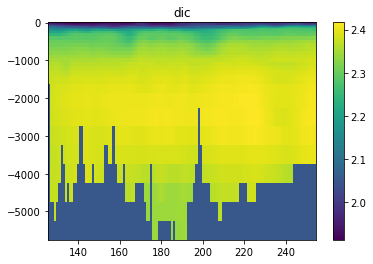

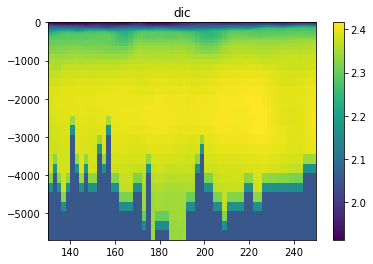

Working on alk


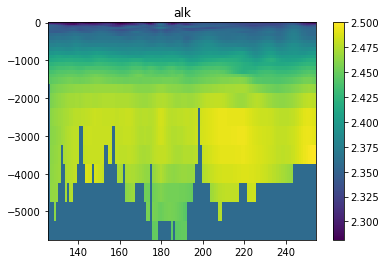

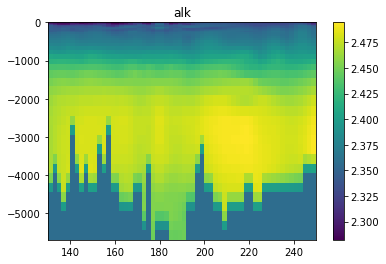

Working on o2


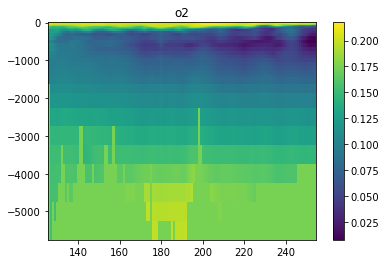

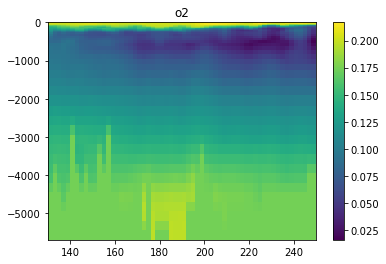

Working on po4


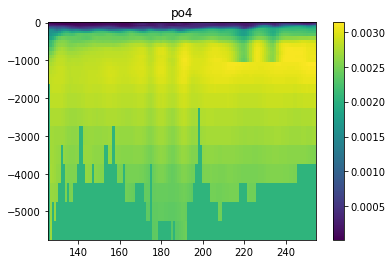

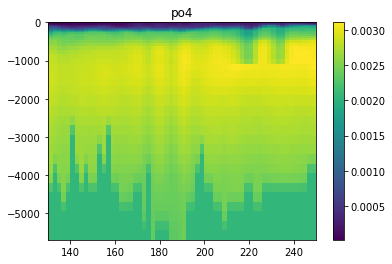

Working on no3


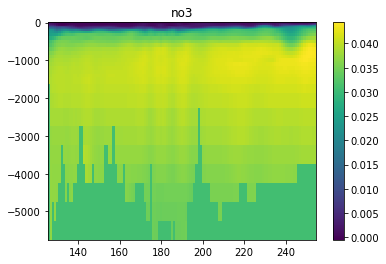

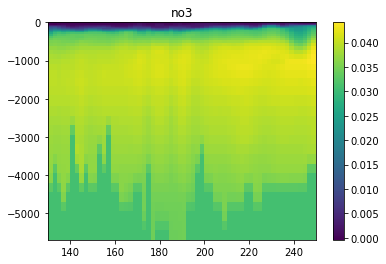

Working on fe


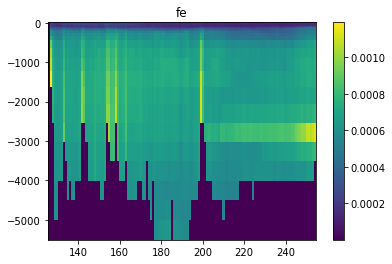

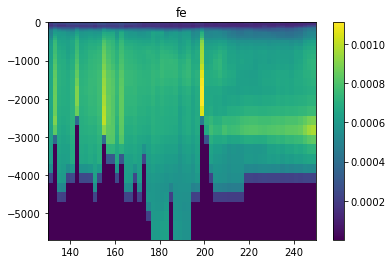

In [6]:
# loop over the variables (nv) 
for nv in range(6):
    if nv==5:
        ds=xr.open_dataset(ffe)
        fac=1e-3
        ds['Longitude']=ds['Longitude']+180
        x=ds.Longitude.to_numpy()
        y=ds.Latitude.to_numpy()
        z=ds.Depth.to_numpy()
        z[0]=0
        data = ds[vars0[nv]].roll(Longitude=int(360/2))
    else:
        ds=xr.open_dataset(srcdir+'/GLODAPv2.'+vars0[nv]+'.nc')
        fac=1
        ds['lon']=ds['lon']+180
        x=ds.lon.to_numpy()
        y=ds.lat.to_numpy()
        z=ds.Pressure.to_numpy()
        # roll longitude coordinate
        data = ds[vars0[nv]].roll(lon=int(360/2))
    #
    if nv==0:
        data0 = data[0,:,:,:].to_numpy()
    elif nv==5:
        data0 = data[12,:,:,:].to_numpy()
    else:
        data0=data.to_numpy()
    da=xr.DataArray(data=data0,name=vars1[nv],dims=['depth','lat','lon'],
               coords={'depth':z,'lat':y,'lon':x})
    ds1=da.to_dataset()
##
    print(f'Working on {vars1[nv]}')
    I = np.where((x >= xn[0]) & (x <= xn[-1]))[0]
    J = np.where((y >= yn[0]) & (y <= yn[-1]))[0]
    Iw = np.where((x >= xn[0] - 5) & (x <= xn[-1] + 5))[0]
    Jw = np.where((y >= yn[0] - 5) & (y <= yn[-1] + 5))[0]
    # Side boundary condition
    Nz = z.shape[0]
    tmp= data0*1025e-6
    count=0
    
    # Eastern boundary
    tmpE = tmp[:, Jw, I[-1]]
    for k in range(len(z)):
        tmpEk = tmpE[k,:]
        tmpEkm = np.nanmean(tmpEk,axis=0)
        tmpEk[np.isnan(tmpEk)] = vref[nv]*1025e-6
        tmpE[k, :] = tmpEk
    tmpmap = RectBivariateSpline(z, y[Jw], tmpE, kx=1, ky=1)
    tmpE1[nv, count, :, :] =  tmpmap(zn, yn)
            
    # Western boundary
    tmpW = tmp[:, Jw, I[0]]
    for k in range(len(z)):
        tmpWk = tmpW[k,:]
        tmpWkm = np.nanmean(tmpWk,axis=0)
        tmpWk[np.isnan(tmpWk)] = vref[nv]*1025e-6
        tmpW[k, :] = tmpWk
    tmpmap = RectBivariateSpline(z, y[Jw],tmpW, kx=1, ky=1)
    tmpW1[nv, count, :, :] =  tmpmap(zn, yn)
            
    # Northern boundary
    tmpN = tmp[:, J[-1], Iw]
    for k in range(len(z)):
        tmpNk = tmpN[k,:]
        tmpNkm = np.nanmean(tmpNk,axis=0)
        tmpNk[np.isnan(tmpNk)] = vref[nv]*1025e-6
        tmpN[k, :] = tmpNk
    tmpmap = RectBivariateSpline(z, x[Iw],tmpN, kx=1, ky=1)
    tmpN1[nv, count, :, :] =  tmpmap(zn, xn)
            
    # Southern boundary
    tmpS = tmp[:, J[0], Iw]
    for k in range(len(z)):
        tmpSk = tmpS[k,:]
        tmpSkm = np.nanmean(tmpSk,axis=0)
        tmpSk[np.isnan(tmpSk)] = vref[nv]*1025e-6
        tmpS[k, :] = tmpSk
    tmpmap = RectBivariateSpline(z, x[Iw],tmpS, kx=1, ky=1)
    tmpS1[nv, count, :, :] =  tmpmap(zn, xn)
            
    plt.pcolormesh(x[Iw], -z, tmpS)
    plt.colorbar()
    plt.title(vars1[nv])
    plt.show()
    plt.pcolormesh(xn, -zn, tmpS1[nv,count,:,:])
    plt.colorbar()
    plt.title(vars1[nv])
    plt.show()

In [7]:
for n in np.arange(1,12,1):
    tmpN1[:, n, :, :] =  tmpN1[:, 0, :, :]
    tmpS1[:, n, :, :] =  tmpS1[:, 0, :, :]
    tmpE1[:, n, :, :] =  tmpE1[:, 0, :, :]
    tmpW1[:, n, :, :] =  tmpW1[:, 0, :, :]
    

In [8]:
for n, var in enumerate(vars1):
    # East
    fn = f'{caseroot}/{var}_east_clim.bin'
    print(fn)
    xm.utils.write_to_binary(tmpE1[n,:,:,:].flatten(), fn)
    # West
    fn = f'{caseroot}/{var}_west_clim.bin'
    print(fn)
    xm.utils.write_to_binary(tmpW1[n,:,:,:].flatten(), fn)
    # North
    fn = f'{caseroot}/{var}_north_clim.bin'
    print(fn)
    xm.utils.write_to_binary(tmpN1[n,:,:,:].flatten(), fn)
    # South
    fn = f'{caseroot}/{var}_south_clim.bin'
    print(fn)
    xm.utils.write_to_binary(tmpS1[n,:,:,:].flatten(), fn)

.//dic_east_clim.bin
.//dic_west_clim.bin
.//dic_north_clim.bin
.//dic_south_clim.bin
.//alk_east_clim.bin
.//alk_west_clim.bin
.//alk_north_clim.bin
.//alk_south_clim.bin
.//o2_east_clim.bin
.//o2_west_clim.bin
.//o2_north_clim.bin
.//o2_south_clim.bin
.//po4_east_clim.bin
.//po4_west_clim.bin
.//po4_north_clim.bin
.//po4_south_clim.bin
.//no3_east_clim.bin
.//no3_west_clim.bin
.//no3_north_clim.bin
.//no3_south_clim.bin
.//fe_east_clim.bin
.//fe_west_clim.bin
.//fe_north_clim.bin
.//fe_south_clim.bin
